# LAB 3

Jean-Loup Mellion  
Gatien Da Rocha

# Imports / CUDA

In [84]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

%matplotlib inline
np.random.seed(7)

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)
!nvidia-smi

cuda
Thu Jun  6 18:11:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.78                 Driver Version: 550.78         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   65C    P0             28W /   80W |    2218MiB /   6144MiB |     15%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

# Params

The parameters used in all the following models

In [85]:
EPOCHS = 32
BATCH_SIZE = 256

# Dataset

We add some transformations to the dataset, color jittering, cropping, flipping, and normalization.  
Normalization is not exactly the one recommended for CIFAR10, but it is the one used by ResNet and SqueezeNet, so we will use it for the sake of comparison.

In [86]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
)

train_set = torchvision.datasets.CIFAR10('DATA_CIFAR/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=7)

validation_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

validation_set = torchvision.datasets.CIFAR10('DATA_CIFAR/', download=True, train=False, transform=validation_transform)
validationLoader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=7)

print("Train size : ", len(train_set))
print("validation size : ", len(validation_set))

training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)

print(images.shape)
print(labels.shape)

Files already downloaded and verified
Files already downloaded and verified
Train size :  50000
validation size :  10000
torch.Size([256, 3, 32, 32])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5303762..1.5744561].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68545556..1.5825797].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6660706..1.1493894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.65637815..1.769559].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6369933..1.3110672].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7145

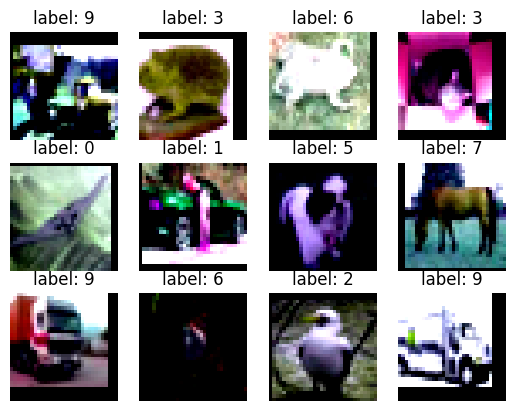

In [87]:
for i in range(0,12):
    plt.subplot(3, 4, i+1)
    plt.imshow((images[i]/ 2 + 0.5).permute(1,2,0).numpy()); plt.axis('off')
    plt.title("label: " + str(labels[i].numpy().squeeze()))

# Training / Plotting / Evaluation functions

In [88]:
def train_model(
        model: torch.nn.Module,
        trainLoader: torch.utils.data.DataLoader,
        validationLoader: torch.utils.data.DataLoader,
        train_set: torch.utils.data.Dataset,
        validation_set: torch.utils.data.Dataset,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        device: str,
        model_path: str,
        save_every: int,
        epochs: int = 8
) -> tuple:
    train_loss, val_loss = [], []
    accuracy_total_train, accuracy_total_val = [], []
    start_time = time.time()
    last_time = start_time

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0
        model.train()
        total = 0

        for idx, (image, label) in enumerate(trainLoader):
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()

            pred = model(image)
            loss = criterion(pred, label)

            total_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    total += 1

        accuracy_train = total / len(train_set)
        accuracy_total_train.append(accuracy_train)
        total_train_loss = total_train_loss / (idx + 1)
        train_loss.append(total_train_loss)

        model.eval()
        total = 0

        with torch.no_grad():
            for idx, (image, label) in enumerate(validationLoader):
                image, label = image.to(device), label.to(device)

                pred = model(image)
                loss = criterion(pred, label)

                total_val_loss += loss.item()
                pred = torch.nn.functional.softmax(pred, dim=1)
                for i, p in enumerate(pred):
                    if label[i] == torch.max(p.data, 0)[1]:
                        total += 1

        accuracy_val = total / len(validation_set)
        accuracy_total_val.append(accuracy_val)
        total_val_loss = total_val_loss / (idx + 1)
        val_loss.append(total_val_loss)

        print("Epoch: {}/{}  ".format(epoch + 1, epochs),
              "Train loss: {:.4f}  ".format(total_train_loss),
              "Valid loss: {:.4f}  ".format(total_val_loss),
              "Train acc: {:.4f}  ".format(accuracy_train),
              "Valid acc: {:.4f}  ".format(accuracy_val),
              "Elapsed time: {:.4f} sec  ".format(time.time() - start_time),
              "Time left: {:.4f} sec".format((time.time() - last_time) * (epochs - epoch - 1)))

        last_time = time.time()

        if epoch != 0 and save_every != 0 and (epoch + 1) % save_every == 0:
            torch.save(model.state_dict(), model_path + "epoch_" + str(epoch) + ".pt")
            print("Model saved!")

    total_time = time.time() - start_time

    return train_loss, val_loss, accuracy_total_train, accuracy_total_val, total_time

In [89]:
def plot_loss(train_loss: list, val_loss: list):
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per epoch')
    plt.show()

In [90]:
def plot_accuracy(accuracy_total_train: list, accuracy_total_val: list):
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy_total_train, label='Training accuracy')
    plt.plot(accuracy_total_val, label='Validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per epoch')
    plt.show()

In [91]:
def test_accuracy(model: torch.nn.Module, validationLoader: torch.utils.data.DataLoader, validation_set: torch.utils.data.Dataset, device: str) -> float:
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(validationLoader):
        image, label = image.to(device), label.to(device)
        with torch.no_grad():
            pred = model(image)
            pred = torch.nn.functional.softmax(pred, dim=1)
            for i, p in enumerate(pred):
                if label[i] == torch.max(p.data, 0)[1]:
                    total = total + 1

    accuracy = total / len(validation_set)
    return accuracy

In [92]:
def trainable_parameters(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in filter(lambda p: p.requires_grad, model.parameters()))

# From scratch model

### Model

In [93]:
class ResidualBlock(torch.nn.Module):
    """
    Residual block with three convolutions
    """ 
    def __init__(self, in_channels: int = 3, out_channels: int = 64, kernel_size: int = 3, padding: int = 1):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.prelu1 = torch.nn.PReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.prelu2 = torch.nn.PReLU()
        self.residual_conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0) if in_channels != out_channels else None
        self.maxpool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        residual = x
        out = self.conv1(x) # in, w, h -> out, w, h
        out = self.bn1(out) # out, w, h
        out = self.prelu1(out) # out, w, h
        out = self.conv2(out) # out, w, h -> out, w, h
        out = self.bn2(out) # out, w, h
        if self.residual_conv: 
            residual = self.residual_conv(x) # in, w, h -> out, w, h
        out += residual # out, w, h
        out = self.prelu2(out) # out, w, h
        out = self.maxpool(out) # out, w, h -> out, w/2, h/2
        return out
        
    
class Classifier(torch.nn.Module):
    """
    Simple classifier with two fully connected layers
    """
    def __init__(self, in_channels: int):
        super().__init__()
        self.dropout1 = torch.nn.Dropout(0.2)
        self.fc1 = torch.nn.Linear(in_channels, 128)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, out):
        out = out.view(out.size(0), -1) # 2x2x256 -> 2048
        out = self.dropout1(out) # 2048
        out = self.fc1(out) # 2048 -> 128
        out = self.dropout2(out) # 128
        out = self.fc2(out) # 128 -> 10
        return out

class FromScratch(torch.nn.Module):
    """
    Model from scratch, inspired by ResNet models
    """
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.batchnorm = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.block1 = ResidualBlock(64, 96, kernel_size=3, padding=1)
        self.block2 = ResidualBlock(96, 128, kernel_size=3, padding=1)
        self.block3 = ResidualBlock(128, 196, kernel_size=3, padding=1)
        self.block4 = ResidualBlock(196, 256, kernel_size=3, padding=1)
        self.classifier = Classifier(256 * 2 * 2)
    
    def forward(self, out):
        out = self.conv(out) # 32x32x3 -> 32x32x64
        out = self.batchnorm(out) # 32x32x64
        out = self.relu(out) # 32x32x64
        out = self.block1(out) # 32x32x64 -> 16x16x96
        out = self.block2(out) # 16x16x96 -> 8x8x128
        out = self.block3(out) # 8x8x128 -> 4x4x192
        out = self.block4(out) # 4x4x192 -> 2x2x256
        out = self.classifier(out) # 2x2x256 -> 10
        return out

model_from_scratch = FromScratch()
model_from_scratch.to(device)

total_parameters_from_scratch = trainable_parameters(model_from_scratch)
print(f"Number of total trainable parameters: {total_parameters_from_scratch}")

optimizer = torch.optim.AdamW(model_from_scratch.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

Number of total trainable parameters: 2242078


### Training

In [94]:
train_loss_from_scratch, val_loss_from_scratch, accuracy_total_train_from_scratch, accuracy_total_val_from_scratch, total_time_from_scratch = train_model(
    model_from_scratch,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model_from_scratch/",
    0,
    EPOCHS
)

Epoch: 1/32   Train loss: 1.6165   Valid loss: 1.2600   Train acc: 0.4101   Valid acc: 0.5488   Elapsed time: 24.3378 sec   Time left: 754.4724 sec
Epoch: 2/32   Train loss: 0.9937   Valid loss: 0.9897   Train acc: 0.6472   Valid acc: 0.6734   Elapsed time: 48.5664 sec   Time left: 726.8521 sec
Epoch: 3/32   Train loss: 0.7583   Valid loss: 0.7022   Train acc: 0.7348   Valid acc: 0.7598   Elapsed time: 73.0792 sec   Time left: 710.8658 sec
Epoch: 4/32   Train loss: 0.6223   Valid loss: 0.6932   Train acc: 0.7844   Valid acc: 0.7712   Elapsed time: 97.0279 sec   Time left: 670.5535 sec
Epoch: 5/32   Train loss: 0.5436   Valid loss: 0.6421   Train acc: 0.8143   Valid acc: 0.7906   Elapsed time: 121.4660 sec   Time left: 659.8252 sec
Epoch: 6/32   Train loss: 0.4745   Valid loss: 0.4968   Train acc: 0.8371   Valid acc: 0.8326   Elapsed time: 146.9052 sec   Time left: 661.4108 sec
Epoch: 7/32   Train loss: 0.4248   Valid loss: 0.5067   Train acc: 0.8542   Valid acc: 0.8315   Elapsed time: 

### Evaluation

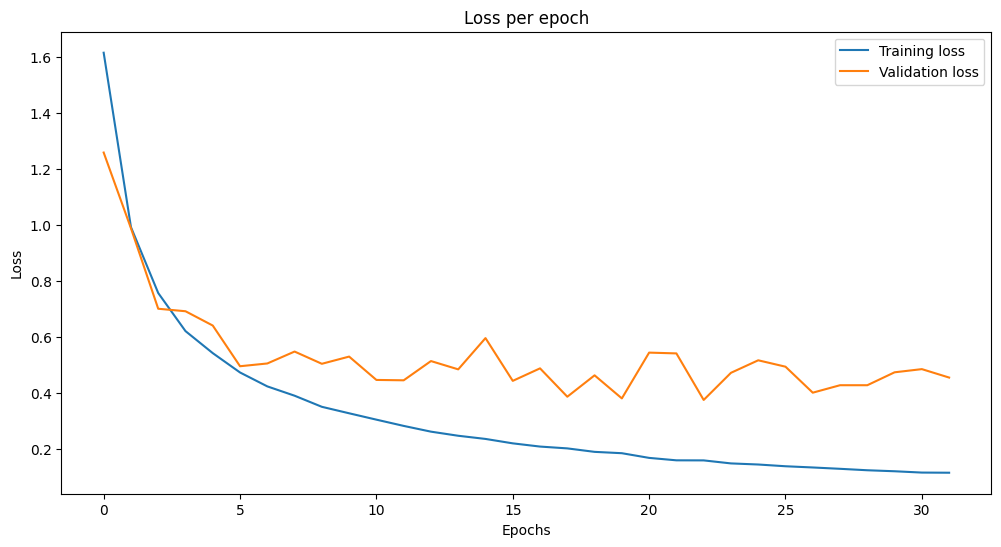

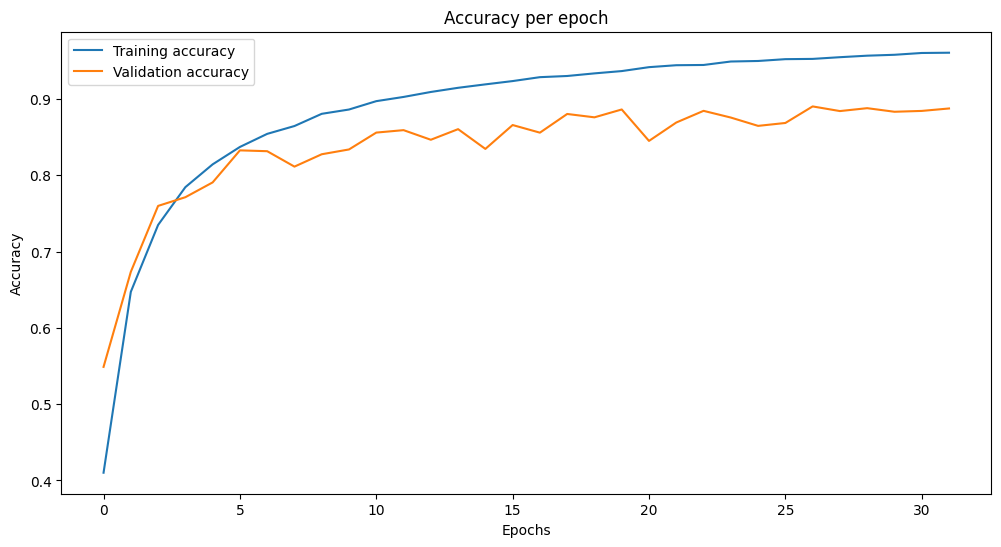

Accuracy:  0.8875


In [95]:
plot_loss(train_loss_from_scratch, val_loss_from_scratch)
plot_accuracy(accuracy_total_train_from_scratch, accuracy_total_val_from_scratch)

accuracy_from_scratch = test_accuracy(model_from_scratch, validationLoader, validation_set, device)
print("Accuracy: ", accuracy_from_scratch)

# CNN1 ResNet Features extraction

### Model

In [96]:
# Importing the model
model_resnet_extract = torchvision.models.resnet18(pretrained=True)
print(model_resnet_extract)

# Freezing the convolutional layers
for param in model_resnet_extract.parameters():
    param.requires_grad = False

# Changing the output layer (from 1000 classes to 10)
model_resnet_extract.fc = torch.nn.Linear(512, 10)
print(model_resnet_extract)
total_parameters_resnet_extract = trainable_parameters(model_resnet_extract)
print(f"Number of total trainable parameters: {total_parameters_resnet_extract}")

model_resnet_extract.to(device)
optimizer = torch.optim.AdamW(model_resnet_extract.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [97]:
train_loss_resnet_extract, val_loss_resnet_extract, accuracy_total_train_resnet_extract, accuracy_total_val_resnet_extract, total_time_resnet_extract = train_model(
    model_resnet_extract,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model_resnet_extract/",
    0,
    EPOCHS
)

Epoch: 1/32   Train loss: 1.9919   Valid loss: 1.8100   Train acc: 0.2957   Valid acc: 0.3601   Elapsed time: 10.6009 sec   Time left: 328.6286 sec
Epoch: 2/32   Train loss: 1.8250   Valid loss: 1.7731   Train acc: 0.3630   Valid acc: 0.3776   Elapsed time: 19.7663 sec   Time left: 274.9552 sec
Epoch: 3/32   Train loss: 1.7884   Valid loss: 1.7360   Train acc: 0.3723   Valid acc: 0.3843   Elapsed time: 29.5583 sec   Time left: 283.9653 sec
Epoch: 4/32   Train loss: 1.7785   Valid loss: 1.7683   Train acc: 0.3777   Valid acc: 0.3847   Elapsed time: 38.5980 sec   Time left: 253.1061 sec
Epoch: 5/32   Train loss: 1.7752   Valid loss: 1.7577   Train acc: 0.3789   Valid acc: 0.3846   Elapsed time: 48.8095 sec   Time left: 275.7044 sec
Epoch: 6/32   Train loss: 1.7694   Valid loss: 1.7161   Train acc: 0.3811   Valid acc: 0.3995   Elapsed time: 59.4406 sec   Time left: 276.4035 sec
Epoch: 7/32   Train loss: 1.7660   Valid loss: 1.7188   Train acc: 0.3847   Valid acc: 0.3970   Elapsed time: 70

### Evaluation

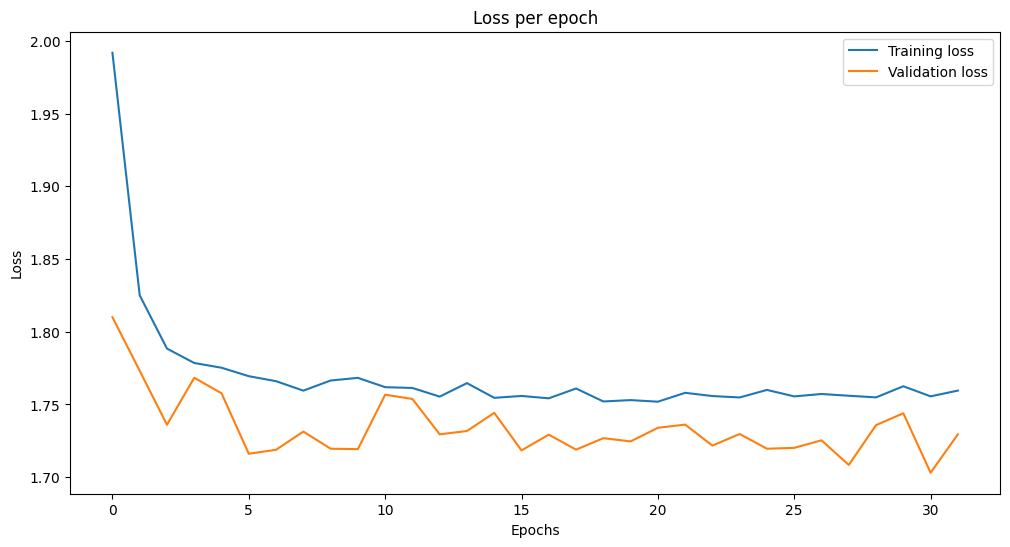

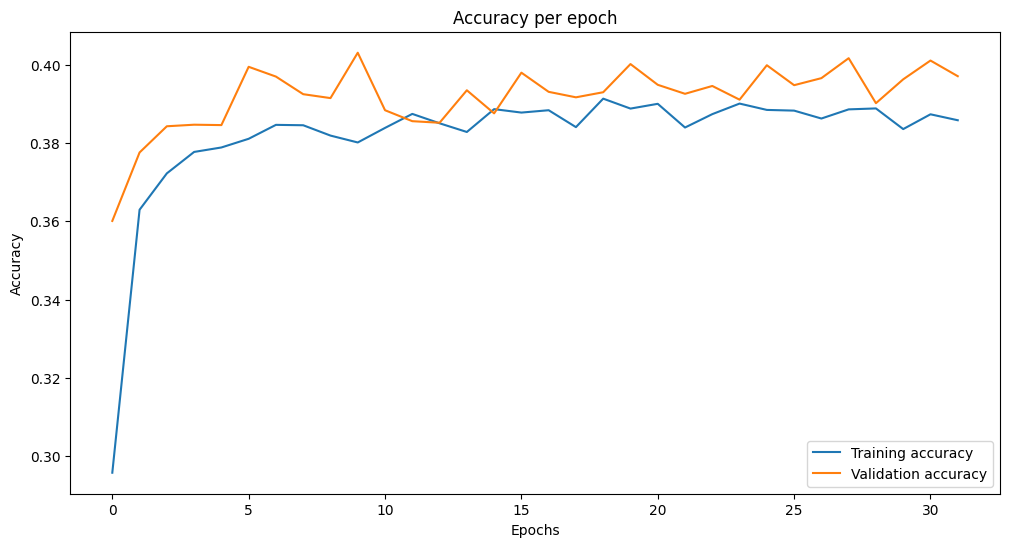

Accuracy:  0.3971


In [98]:
plot_loss(train_loss_resnet_extract, val_loss_resnet_extract)
plot_accuracy(accuracy_total_train_resnet_extract, accuracy_total_val_resnet_extract)

accuracy_resnet_extract = test_accuracy(model_resnet_extract, validationLoader, validation_set, device)
print("Accuracy: ", accuracy_resnet_extract)

# CNN1 ResNet Fine-tuning

### Model

In [99]:
# Importing the model
model_resnet_finetune = torchvision.models.resnet18(pretrained=True)
print(model_resnet_finetune)

# Freezing the convolutional layers except the last one (yes the last layer make +75% of the total parameters)
for param in model_resnet_finetune.parameters():
    param.requires_grad = False
for param in model_resnet_finetune.layer4.parameters():
    param.requires_grad = True

# Changing the output layer (from 1000 classes to 10)
model_resnet_finetune.fc = torch.nn.Linear(512, 10)
print(model_resnet_finetune)
total_parameters_resnet_finetune = trainable_parameters(model_resnet_finetune)
print(f"Number of total trainable parameters: {total_parameters_resnet_finetune}")

model_resnet_finetune.to(device)
optimizer = torch.optim.AdamW(model_resnet_finetune.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [100]:
train_loss_resnet_finetune, val_loss_resnet_finetune, accuracy_total_train_resnet_finetune, accuracy_total_val_resnet_finetune, total_time_resnet_finetune = train_model(
    model_resnet_finetune,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model_resnet_finetune/",
    0,
    EPOCHS
)

Epoch: 1/32   Train loss: 1.3764   Valid loss: 1.4056   Train acc: 0.5164   Valid acc: 0.5812   Elapsed time: 8.8898 sec   Time left: 275.5836 sec
Epoch: 2/32   Train loss: 1.1467   Valid loss: 1.0781   Train acc: 0.5985   Valid acc: 0.6319   Elapsed time: 17.1757 sec   Time left: 248.5709 sec
Epoch: 3/32   Train loss: 1.0877   Valid loss: 1.0911   Train acc: 0.6175   Valid acc: 0.6424   Elapsed time: 24.6103 sec   Time left: 215.6000 sec
Epoch: 4/32   Train loss: 1.0404   Valid loss: 0.9926   Train acc: 0.6358   Valid acc: 0.6585   Elapsed time: 32.1747 sec   Time left: 211.8013 sec
Epoch: 5/32   Train loss: 1.0048   Valid loss: 0.9827   Train acc: 0.6450   Valid acc: 0.6644   Elapsed time: 39.5417 sec   Time left: 198.9008 sec
Epoch: 6/32   Train loss: 0.9852   Valid loss: 0.9625   Train acc: 0.6526   Valid acc: 0.6615   Elapsed time: 47.1780 sec   Time left: 198.5419 sec
Epoch: 7/32   Train loss: 0.9647   Valid loss: 1.0546   Train acc: 0.6584   Valid acc: 0.6710   Elapsed time: 54.

### Evaluation

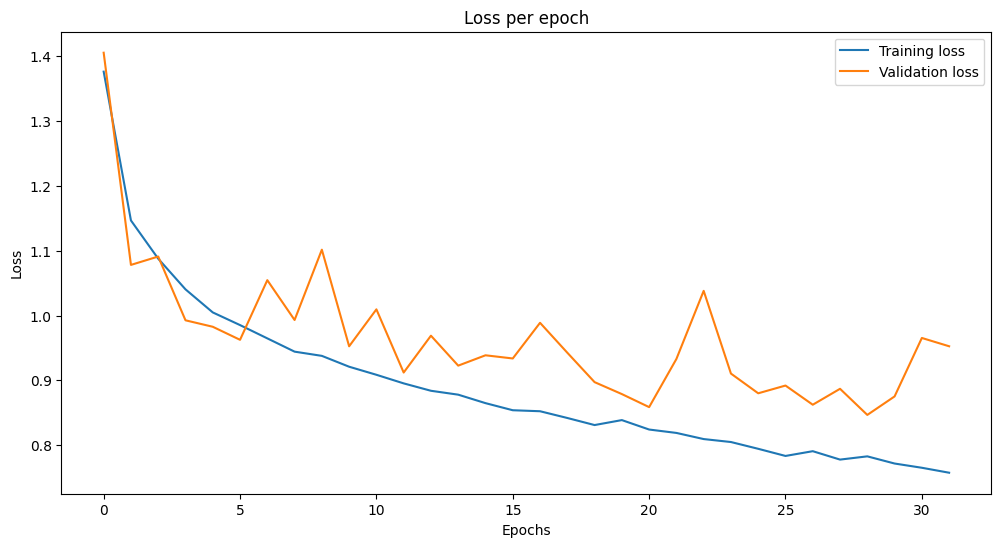

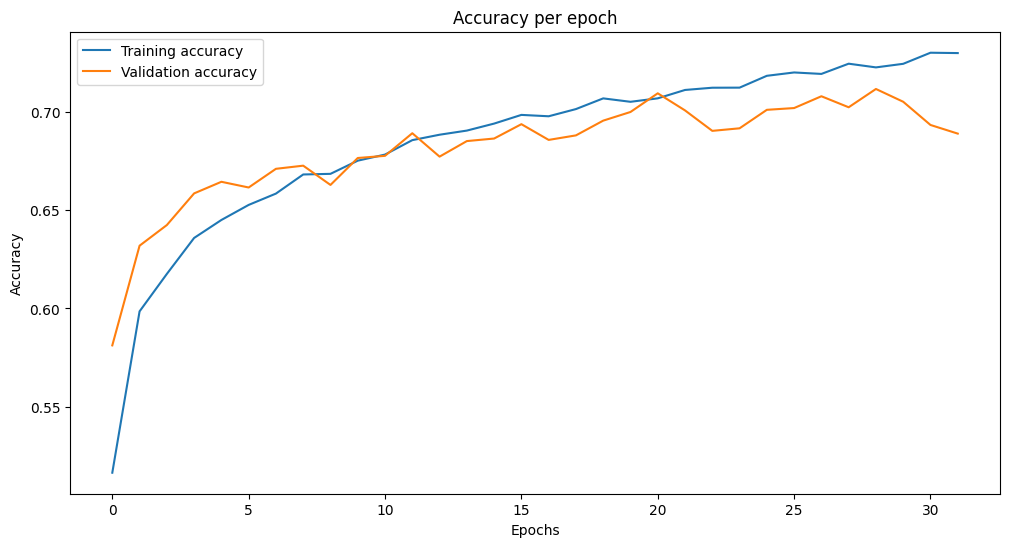

Accuracy:  0.6889


In [101]:
plot_loss(train_loss_resnet_finetune, val_loss_resnet_finetune)
plot_accuracy(accuracy_total_train_resnet_finetune, accuracy_total_val_resnet_finetune)

accuracy_resnet_finetune = test_accuracy(model_resnet_finetune, validationLoader, validation_set, device)
print("Accuracy: ", accuracy_resnet_finetune)

# CNN2 SqueezeNet Features extraction

### Model

In [116]:
# Importing the model
model_squeezenet_extract = torchvision.models.squeezenet1_1(pretrained=True)
print(model_squeezenet_extract)

# Freezing the features layers
for param in model_squeezenet_extract.features.parameters():
    param.requires_grad = False

# Changing the classifier layer (from 1000 classes to 10)
model_squeezenet_extract.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Conv2d(512, 10, kernel_size=1),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
)
print(model_squeezenet_extract)
total_parameters_squeezenet_extract = trainable_parameters(model_squeezenet_extract)
print(f"Number of total trainable parameters: {total_parameters_squeezenet_extract}")

model_squeezenet_extract.to(device)
optimizer = torch.optim.AdamW(model_squeezenet_extract.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

### Training

In [117]:
train_loss_squeezenet_extract, val_loss_squeezenet_extract, accuracy_total_train_squeezenet_extract, accuracy_total_val_squeezenet_extract, total_time_squeezenet_extract = train_model(
    model_squeezenet_extract,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model_squeezenet_extract/",
    0,
    EPOCHS
)

Epoch: 1/32   Train loss: 2.5773   Valid loss: 2.2985   Train acc: 0.1051   Valid acc: 0.1007   Elapsed time: 10.4393 sec   Time left: 323.6175 sec
Epoch: 2/32   Train loss: 2.2999   Valid loss: 2.2919   Train acc: 0.1024   Valid acc: 0.1060   Elapsed time: 21.1939 sec   Time left: 322.6353 sec
Epoch: 3/32   Train loss: 2.2973   Valid loss: 2.2671   Train acc: 0.1067   Valid acc: 0.1179   Elapsed time: 30.1982 sec   Time left: 261.1167 sec
Epoch: 4/32   Train loss: 2.2873   Valid loss: 2.2683   Train acc: 0.1094   Valid acc: 0.1284   Elapsed time: 38.2143 sec   Time left: 224.4486 sec
Epoch: 5/32   Train loss: 2.2806   Valid loss: 2.2608   Train acc: 0.1103   Valid acc: 0.1169   Elapsed time: 45.6901 sec   Time left: 201.8405 sec
Epoch: 6/32   Train loss: 2.2733   Valid loss: 2.2365   Train acc: 0.1123   Valid acc: 0.1253   Elapsed time: 53.0686 sec   Time left: 191.8397 sec
Epoch: 7/32   Train loss: 2.2680   Valid loss: 2.2320   Train acc: 0.1196   Valid acc: 0.1330   Elapsed time: 61

### Evaluation

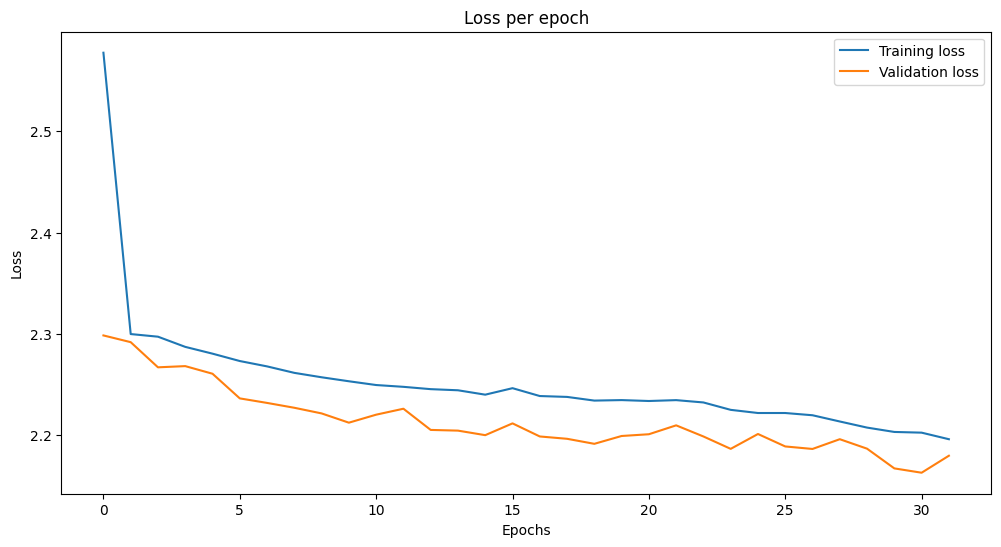

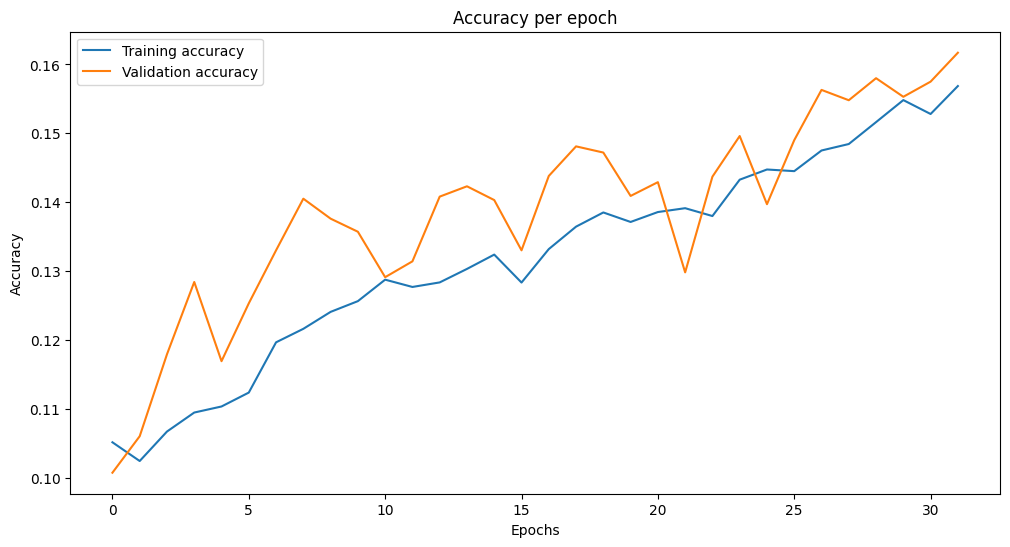

Accuracy:  0.1617


In [118]:
plot_loss(train_loss_squeezenet_extract, val_loss_squeezenet_extract)
plot_accuracy(accuracy_total_train_squeezenet_extract, accuracy_total_val_squeezenet_extract)

accuracy_squeezenet_extract = test_accuracy(model_squeezenet_extract, validationLoader, validation_set, device)
print("Accuracy: ", accuracy_squeezenet_extract)

# CNN2 SqueezeNet Fine-tuning

### Model

In [112]:
# Importing the model
model_squeezenet_finetune = torchvision.models.squeezenet1_1(pretrained=True)
total_parameters = sum(p.numel() for p in model_squeezenet_finetune.parameters())
print(f"Number of total trainable parameters: {total_parameters}")
print(model_squeezenet_finetune)

# Freezing the features layers except the last two ones
for param in model_squeezenet_finetune.features[:-2].parameters():
    param.requires_grad = False

# Changing the classifier layer (from 1000 classes to 10)
model_squeezenet_finetune.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5),
    torch.nn.Conv2d(512, 10, kernel_size=(1, 1)),
    torch.nn.ReLU(inplace=True),
    torch.nn.AdaptiveAvgPool2d((1, 1))
)
print(model_squeezenet_finetune)
total_parameters_squeezenet_finetune = trainable_parameters(model_squeezenet_finetune)
print(f"Number of total trainable parameters: {total_parameters_squeezenet_finetune}")

model_squeezenet_finetune.to(device)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model_squeezenet_finetune.parameters()), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

Number of total trainable parameters: 1235496
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation

### Training

In [113]:
train_loss_squeezenet_finetune, val_loss_squeezenet_finetune, accuracy_total_train_squeezenet_finetune, accuracy_total_val_squeezenet_finetune, total_time_squeezenet_finetune = train_model(
    model_squeezenet_finetune,
    trainLoader,
    validationLoader,
    train_set,
    validation_set,
    criterion,
    optimizer,
    device,
    "model_squeezenet_finetune/",
    0,
    EPOCHS
)

Epoch: 1/32   Train loss: 2.2433   Valid loss: 2.0121   Train acc: 0.1754   Valid acc: 0.3083   Elapsed time: 14.5654 sec   Time left: 451.5260 sec
Epoch: 2/32   Train loss: 2.0260   Valid loss: 1.8185   Train acc: 0.2556   Valid acc: 0.3585   Elapsed time: 28.6775 sec   Time left: 423.3556 sec
Epoch: 3/32   Train loss: 1.9101   Valid loss: 1.7317   Train acc: 0.3202   Valid acc: 0.3905   Elapsed time: 43.1314 sec   Time left: 419.1538 sec
Epoch: 4/32   Train loss: 1.8131   Valid loss: 1.5679   Train acc: 0.3609   Valid acc: 0.4423   Elapsed time: 56.8591 sec   Time left: 384.3720 sec
Epoch: 5/32   Train loss: 1.6992   Valid loss: 1.5116   Train acc: 0.4017   Valid acc: 0.4740   Elapsed time: 68.4151 sec   Time left: 312.0021 sec
Epoch: 6/32   Train loss: 1.6575   Valid loss: 1.4853   Train acc: 0.4202   Valid acc: 0.4783   Elapsed time: 76.4923 sec   Time left: 210.0030 sec
Epoch: 7/32   Train loss: 1.6238   Valid loss: 1.4767   Train acc: 0.4346   Valid acc: 0.4836   Elapsed time: 84

### Evaluation

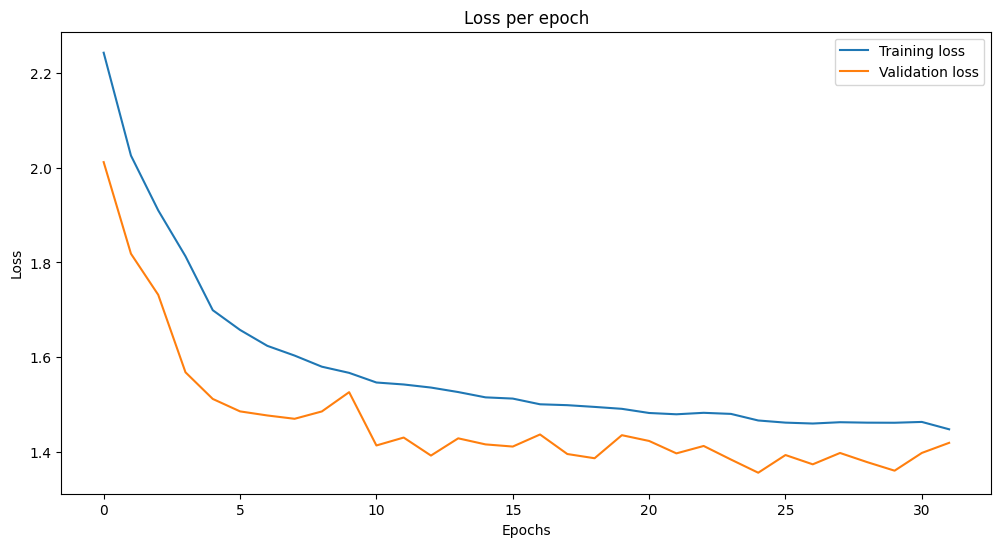

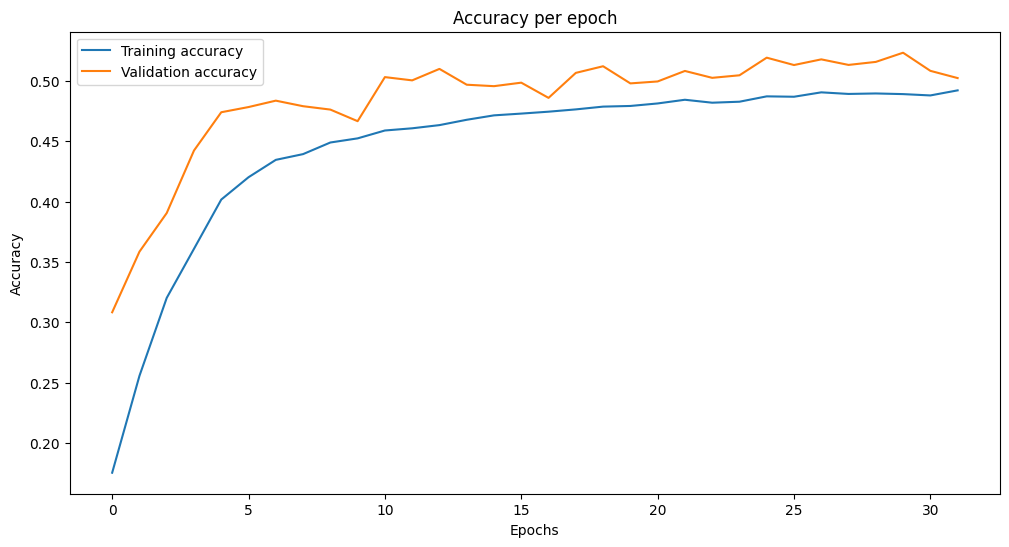

Accuracy:  0.5023


In [114]:
plot_loss(train_loss_squeezenet_finetune, val_loss_squeezenet_finetune)
plot_accuracy(accuracy_total_train_squeezenet_finetune, accuracy_total_val_squeezenet_finetune)

accuracy_squeezenet_finetune = test_accuracy(model_squeezenet_finetune, validationLoader, validation_set, device)
print("Accuracy: ", accuracy_squeezenet_finetune)

# Comparison

### Plot

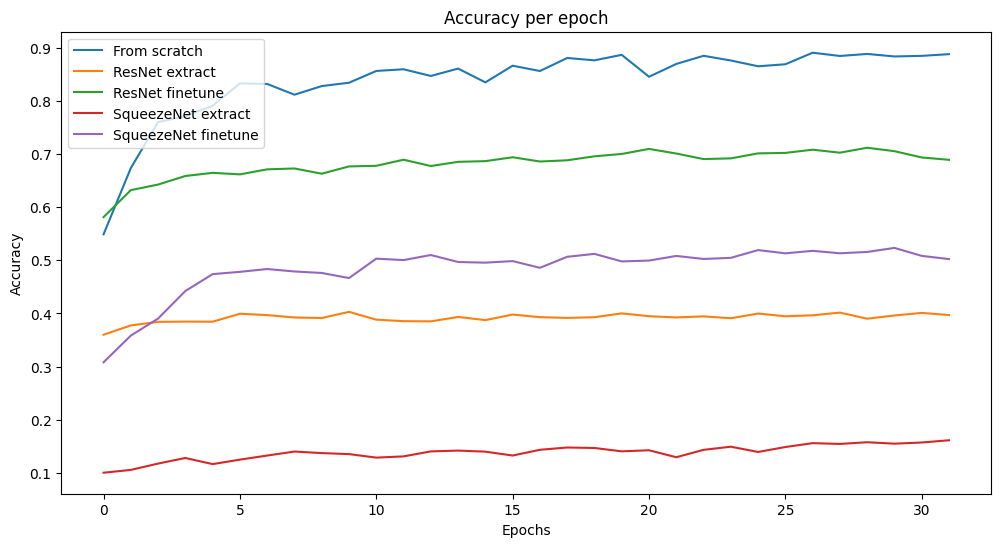

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(accuracy_total_val_from_scratch, label='From scratch')
plt.plot(accuracy_total_val_resnet_extract, label='ResNet extract')
plt.plot(accuracy_total_val_resnet_finetune, label='ResNet finetune')
plt.plot(accuracy_total_val_squeezenet_extract, label='SqueezeNet extract')
plt.plot(accuracy_total_val_squeezenet_finetune, label='SqueezeNet finetune')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per epoch')
plt.show()

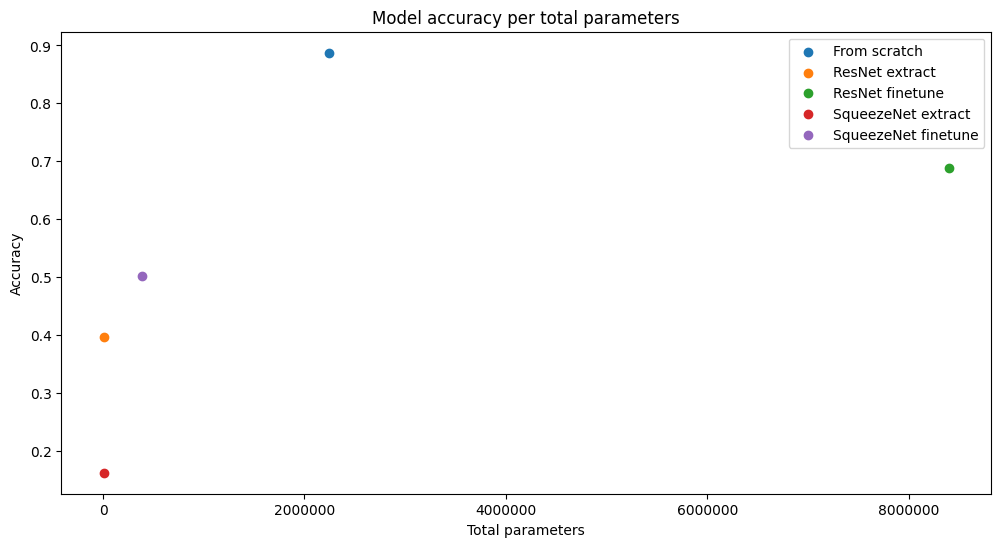

In [121]:
# Plot points model accuracy per parameters count
plt.figure(figsize=(12, 6))
plt.scatter(total_parameters_from_scratch, accuracy_from_scratch, label='From scratch')
plt.scatter(total_parameters_resnet_extract, accuracy_resnet_extract, label='ResNet extract')
plt.scatter(total_parameters_resnet_finetune, accuracy_resnet_finetune, label='ResNet finetune')
plt.scatter(total_parameters_squeezenet_extract, accuracy_squeezenet_extract, label='SqueezeNet extract')
plt.scatter(total_parameters_squeezenet_finetune, accuracy_squeezenet_finetune, label='SqueezeNet finetune')
plt.legend()
plt.xlabel('Total parameters')
plt.ticklabel_format(style='plain', axis='x')
plt.ylabel('Accuracy')
plt.title('Model accuracy per total parameters')
plt.show()

### Table

In [122]:
data = {
    "Model": ["From scratch", "ResNet Extract", "ResNet Finetune", "SqueezeNet Extract", "SqueezeNet Finetune"],
    "Number of trainable parameters": [total_parameters_from_scratch, total_parameters_resnet_extract, total_parameters_resnet_finetune, total_parameters_squeezenet_extract, total_parameters_squeezenet_finetune],
    "Test accuracy": [accuracy_from_scratch, accuracy_resnet_extract, accuracy_resnet_finetune, accuracy_squeezenet_extract, accuracy_squeezenet_finetune],
    "Trainning time per epoch": [total_time_from_scratch / EPOCHS, total_time_resnet_extract / EPOCHS, total_time_resnet_finetune / EPOCHS, total_time_squeezenet_extract / EPOCHS, total_time_squeezenet_finetune / EPOCHS]
}
df = pd.DataFrame(data)
df

,Model,Number of trainable parameters,Test accuracy,Trainning time per epoch
0,From scratch,2242078,0.8875,25.069776
1,ResNet Extract,5130,0.3971,10.388355
2,ResNet Finetune,8398858,0.6889,8.031878
3,SqueezeNet Extract,5130,0.1617,9.495259
4,SqueezeNet Finetune,391306,0.5023,9.576135
